<a href="https://colab.research.google.com/github/agustinperalta/Diplodatos-g18/blob/main/Grupo_18_Entregable_Parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2022**

---

### *Grupo N°:* 18

### *Integrantes:*
#### Parada Larrosa, Francisco
#### Peralta, Agustín
####  Porcel, Carolina
####  Quiros, Agustina


## Trabajo práctico entregable - Parte 2

Fuente test welch: https://stats.stackexchange.com/questions/475289/confidence-interval-for-2-sample-t-test-with-scipy

In [ ]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn as sns
from scipy import stats 
import statsmodels.stats.api as sms

sns.set_context('talk')

## Lectura del dataset

In [ ]:
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df = pd.read_csv(url)

In [ ]:
df[:3]

,profile_gender,profile_age,work_country,work_province,profile_years_experience,work_years_in_company,work_years_in_current_position,work_people_in_charge_of,profile_studies_level,profile_studies_level_state,...,work_has_violence_situations,profile_sexual_orientation,profile_has_disabilities,profile_has_disabilities_hiring_difficulties,company_employee_number,company_main_activity,company_recommended,company_diversity_policies,company_extra_benefits,company_best_companies_city
0,Mujer,26,Argentina,Ciudad Autónoma de Buenos Aires,3.0,3.0,3.0,0,Universitario,En curso,...,En mi trabajo actual,Homosexual,NaN,NaN,501-1000,Servicios / Consultoría de Software / Digital,7,2,"Capacitaciones y/o cursos, Comidas pagas / sub...",NaN
1,Hombre,29,Argentina,Corrientes,5.0,2.0,2.0,4,Universitario,En curso,...,Jamás,Heterosexual,Visual,No,201-500,Otras industrias,8,9,"Horarios flexibles, Stock options / RSUs, Viát...",NaN
2,Mujer,22,Argentina,Ciudad Autónoma de Buenos Aires,2.0,0.0,0.0,0,Secundario,Completado,...,En un trabajo anterior,Bisexual o queer,NaN,No,2001-5000,Otras industrias,6,9,"Clases de gimnasia online, Comidas pagas / sub...",NaN


In [ ]:
df[['profile_gender', 'salary_monthly_NETO']].groupby('profile_gender').describe()

salary_monthly_NETO                                     \
                             count          mean            std   min   
profile_gender                                                          
Hombre                      4944.0  98836.063558  102159.664237   1.0   
Mujer                        908.0  73501.414465   56256.880181   2.0   
Otros                         31.0  95441.354839   88635.674358  40.0   

                                                       
                    25%      50%       75%        max  
profile_gender                                         
Hombre          53285.0  80000.0  110000.0  2080000.0  
Mujer           43818.0  65000.0   92000.0   800000.0  
Otros           39500.0  74000.0  117500.0   380000.0

In [ ]:
df[df.salary_monthly_NETO > 1000]\
  [['profile_gender', 'salary_monthly_NETO']].groupby('profile_gender').describe()

salary_monthly_NETO                                         \
                             count           mean            std      min   
profile_gender                                                              
Hombre                      4815.0  101481.624343  102215.304684   1100.0   
Mujer                        863.0   77328.913778   55082.760570   2000.0   
Otros                         28.0  105660.714286   87235.710235  34000.0   

                                                       
                    25%      50%       75%        max  
profile_gender                                         
Hombre          55000.0  80000.0  110000.0  2080000.0  
Mujer           47850.0  67200.0   93000.0   800000.0  
Otros           43750.0  78900.0  122750.0   380000.0

Text(0.5, 1.0, 'Distribución poblacional de Salario NETO de Hombres')

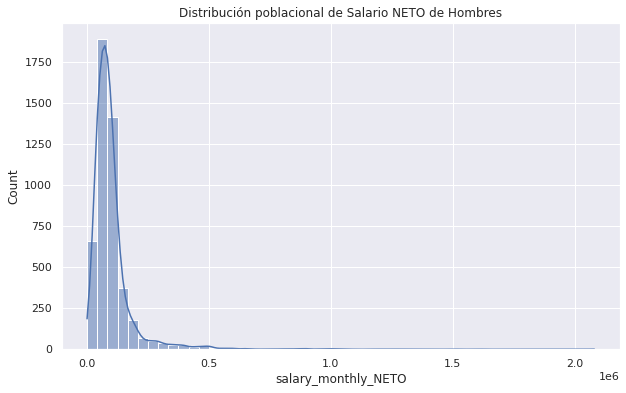

In [ ]:
# Distribución poblacional del grupo A
# Las líneas de KDE son líneas suaves que muestran cómo se distribuyen los datos y pueden ser un buen complemento para los histogramas.
plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
sns.histplot(df[(df.salary_monthly_NETO > 1000) & (df.profile_gender == 'Hombre')]['salary_monthly_NETO'], bins=50, alpha=0.5, kde=True).set_title("Distribución poblacional de Salario NETO de Hombres")

Text(0.5, 1.0, 'Distribución poblacional de Salario NETO de Mujeres')

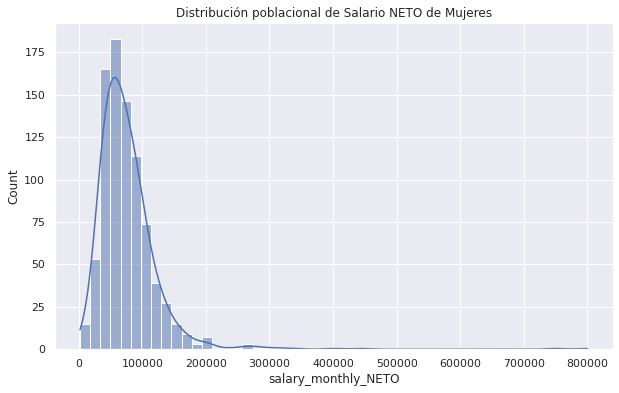

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df[(df.salary_monthly_NETO > 1000) & (df.profile_gender == 'Mujer')]['salary_monthly_NETO'], bins=50, alpha=0.5, kde=True).set_title("Distribución poblacional de Salario NETO de Mujeres")

Como podemos observar, ambas poblaciones parecen tener una distribución asimétrica de los datos. Es por eso que consideramos necesario en primer lugar, limpiar el dataframe de aquellos valores extremos que afectan a la distribución de la variable del salario neto.

In [ ]:
alpha = 0.05

**Limpieza de datos**

Realizamos es una limpieza de los valores extremos por el método de los percentiles.

Para continuar con el mismo criterio del entregable 1, elegimos los percentiles k = 0,05 y k = 0,98 que representan los valores dentro de los cuales trabajamos con anterioridad.

In [ ]:
#Percentiles más altos para filtrar valores extremos derechos
df['salary_monthly_NETO'].quantile([.95, .98, .99, .995, .998])

0.950    210000.00
0.980    370000.00
0.990    491800.00
0.995    650000.00
0.998    955289.52
Name: salary_monthly_NETO, dtype: float64

In [ ]:
#Percentiles más bajos para filtrar valores extremos izquierdos
df['salary_monthly_NETO'].quantile([.02, .05, .1, .15])

0.02       90.0
0.05    22500.0
0.10    35000.0
0.15    40000.0
Name: salary_monthly_NETO, dtype: float64

In [ ]:
# Procedimiento de limpieza
def clean_outliers_p05_p98(dataset, column_name):
    interesting_col = dataset[column_name]
    return dataset[(interesting_col <= (interesting_col.quantile(.98)))  & (interesting_col >= (interesting_col.quantile(0.05)))]

In [ ]:
df = clean_outliers_p05_p98(df, 'salary_monthly_NETO')

In [ ]:
# Nuevo dataframe
df[['profile_gender', 'salary_monthly_NETO']].groupby('profile_gender').describe()

salary_monthly_NETO                                       \
                             count          mean           std      min   
profile_gender                                                            
Hombre                      4608.0  91413.667109  52941.435239  22500.0   
Mujer                        839.0  76356.883897  39715.466819  23000.0   
Otros                         27.0  95500.000000  70006.137094  34000.0   

                                                      
                    25%      50%       75%       max  
profile_gender                                        
Hombre          56487.5  80000.0  108805.0  370000.0  
Mujer           49750.0  68000.0   93885.0  340000.0  
Otros           42500.0  76800.0  117500.0  312000.0

In [ ]:
# Separamos los grupos

is_man = df.profile_gender == 'Hombre'
is_woman = df.profile_gender == 'Mujer'


#groupA = df[(df.salary_monthly_NETO > 1000) & is_man].salary_monthly_NETO
#groupB = df[(df.salary_monthly_NETO > 1000) & ~is_man].salary_monthly_NETO
groupA = df[is_man].salary_monthly_NETO
groupB = df[~is_man].salary_monthly_NETO

Visualizamos distribuciones luego de Procedimiento de limpieza

Text(0.5, 1.0, 'Distribución poblacional de Salario NETO de Hombres')

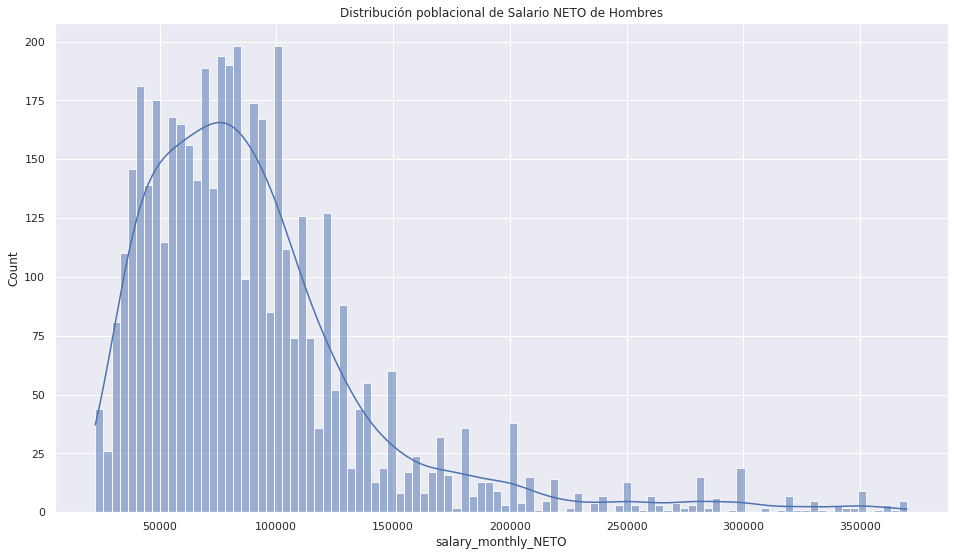

In [ ]:
# Nueva distribución poblacional grupo A
#seaborn.histplot(groupA, bins=100)
plt.figure(figsize=(16, 9))
sns.histplot(groupA, bins=100, alpha=0.5, kde=True).set_title("Distribución poblacional de Salario NETO de Hombres")

Text(0.5, 1.0, 'Distribución poblacional de Salario NETO de Otros')

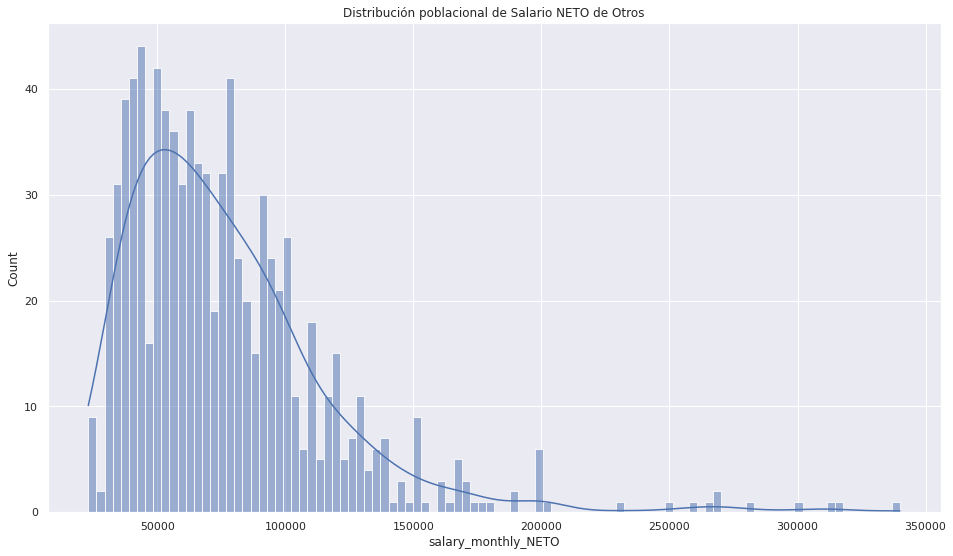

In [ ]:
# Nueva distribución poblacional grupo B
plt.figure(figsize=(16, 9))
sns.histplot(groupB, bins=100, alpha=0.5, kde=True).set_title("Distribución poblacional de Salario NETO de Otros")

Vemos que al haber eliminado los valores extremos, ahora la distribución poblacional tiende a ser más 'normal', aún quedan algunos valores altos en la derecha pero no creemos conveniente seguir eliminando registros.

In [ ]:
# Media poblacional grupo A
media_a = groupA.mean()
media_a

91413.66710937502

In [ ]:
# Media poblacional grupo A
media_b = groupB.mean()
media_b

76953.72469976905

In [ ]:
# Varianza poblacional grupo A
groupA.var() # hombres

2802795565.180625

In [ ]:
# Varianza poblacional grupo B
groupB.var() # otros

1686475125.8318346

## Ejercicio 1: Estimación

**Consigna:**  Calcular una estimación puntual y un intervalo de confianza de nivel (1-alpha) para la resta entre la media del salario Neto para Hombres menos la media del salario Neto para otros géneros(diferencia de las medias entre el grupoA y grupoB). 
¿Cómo se relaciona este intervalo de confianza con el test de hipótesis?

Estimacion Puntual

In [ ]:
len(groupA)

4608

In [ ]:
len(groupB)

866

### *Muestra*

In [ ]:
# Tamaño de la muestra por grupo.
n_A = 4608
n_B = 866


**Estimadores puntuales**

In [ ]:
media_muestra_a = groupA.sample(n_A, replace=False).mean()
media_muestra_a

91413.66710937499

In [ ]:
media_muestra_b = groupB.sample(n_B, replace=False).mean()
media_muestra_b

76953.72469976905

In [ ]:
dif_medias = media_muestra_a - media_muestra_b
dif_medias

14459.942409605937

In [ ]:
groupA.sample(n_A, replace=False)

2795     55000.0
806      85000.0
5717    140000.0
5335     75000.0
5139     99600.0
          ...   
4644     76000.0
2313     37000.0
5242     85000.0
1029     29100.0
1993    175000.0
Name: salary_monthly_NETO, Length: 4608, dtype: float64

In [ ]:
groupB.sample(n_B, replace=False)

4318     60000.0
2679     38700.0
1883     59000.0
1508     53784.0
81       74989.0
          ...   
3997    150000.0
5961    130000.0
4958     65000.0
3818     72000.0
2954     92000.0
Name: salary_monthly_NETO, Length: 866, dtype: float64

In [ ]:
# Muestra grupo A
array_h = groupA.sample(n_A, replace=False).to_numpy()
array_h

array([ 42000.,  55000.,  92000., ..., 140000.,  40591.,  65400.])

In [ ]:
# Muestra grupo B
array_o = groupB.sample(n_B, replace=False).to_numpy()
array_o

array([ 68000.  ,  72300.  ,  32500.  ,  75000.  ,  80000.  ,  40700.  ,
       100909.  ,  94000.  ,  32515.67, 100000.  ,  48000.  ,  73035.  ,
        68000.  ,  90000.  ,  86000.  ,  90000.  ,  55000.  ,  31290.  ,
        32000.  ,  31900.  ,  43000.  ,  80000.  ,  25400.  , 140000.  ,
        73000.  , 110000.  , 120000.  ,  32000.  ,  67000.  ,  75700.  ,
       122000.  ,  85000.  ,  92500.  , 100000.  ,  40000.  ,  50694.  ,
        38834.  ,  53000.  ,  72000.  ,  39000.  ,  33000.  ,  89000.  ,
        43824.  ,  74000.  ,  50000.  ,  26000.  ,  60000.  ,  90784.  ,
        28271.  ,  40500.  ,  67310.  ,  57000.  ,  62000.  ,  75000.  ,
        45000.  ,  37797.  ,  50000.  ,  80000.  , 160000.  ,  67000.  ,
        56403.  , 120000.  , 105000.  ,  75000.  , 105000.  , 120000.  ,
        81000.  ,  57000.  ,  69000.  , 190000.  ,  43800.  , 101000.  ,
        30000.  , 150000.  ,  75000.  , 117000.  ,  66400.  ,  41000.  ,
        92500.  ,  52000.  ,  65000.  ,  70100.  , 

**Cálculo del intervalo de confianza**

Para diferencias de medias con varianzas distintas aplicamos método de Welch.

Cálculo de varianzas poblacionales


In [ ]:
groupA.var()

2802795565.180625

In [ ]:
groupB.var()

1686475125.8318346

In [ ]:
# Funcion para calcular Welch
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import t
import pandas as pd

def welch_ttest(x1, x2):
    
    n1 = x1.size
    n2 = x2.size
    m1 = np.mean(x1)  # Media muestral 1
    m2 = np.mean(x2)  # Media muestral 2
    
    v1 = np.var(x1, ddof=1)
    v2 = np.var(x2, ddof=1)
    
    pooled_se = np.sqrt(v1 / n1 + v2 / n2)
    delta = m1-m2
    
    tstat = delta /  pooled_se
    df = (v1 / n1 + v2 / n2)**2 / (v1**2 / (n1**2 * (n1 - 1)) + v2**2 / (n2**2 * (n2 - 1)))
    
    # two side t-test
    p = 2 * t.cdf(-abs(tstat), df)
    
    # upper and lower bounds
    lb = delta - t.ppf(0.975,df)*pooled_se 
    ub = delta + t.ppf(0.975,df)*pooled_se
  
    return pd.DataFrame(np.array([tstat,df,p,delta,lb,ub]).reshape(1,-1),
                         columns=['T statistic','df','pvalue 2 sided','Difference in mean','lb','ub'])

In [ ]:
welch_ttest(array_h, array_o)

,T statistic,df,pvalue 2 sided,Difference in mean,lb,ub
0,9.045105,1462.921959,4.628559e-19,14459.94241,11324.054819,17595.83


In [ ]:
# Corroboramos el resultado con la siguiente libreria
stats.ttest_ind(array_h, array_o, equal_var=False)

Ttest_indResult(statistic=9.045105354221, pvalue=4.628559359012017e-19)

In [ ]:
cm = sms.CompareMeans(sms.DescrStatsW(array_h), sms.DescrStatsW(array_o))
print (cm.tconfint_diff(usevar='unequal'))

#sms es statsmodels.stats.api

(11324.054818973698, 17595.830000238177)


In [ ]:
groupA.to_numpy()

array([ 63000., 102000., 106000., ...,  97000.,  71000.,  65000.])

Distribución de las muestras

Text(0.5, 1.0, 'Distribución Muestral de Salario NETO de Hombres')

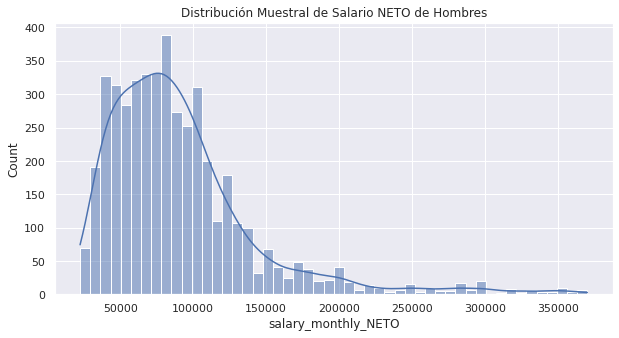

In [ ]:
# Grupo A 
plt.figure(figsize=(10,5))
sns.histplot(groupA.sample(n_A, replace=False), bins=50, kde=True).set_title("Distribución Muestral de Salario NETO de Hombres")

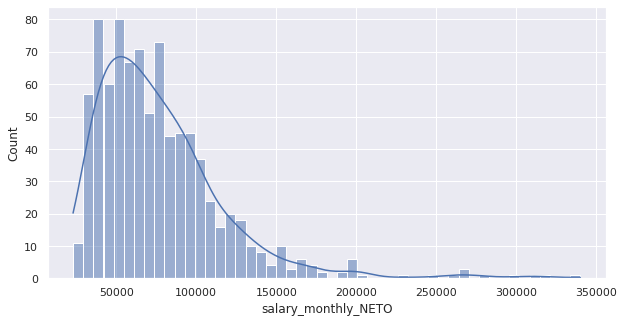

In [ ]:
#Grupo B
#seaborn.histplot(groupB.sample(n_B, replace=False), bins=20)
plt.figure(figsize=(10,5))
sns.histplot(groupB.sample(n_B, replace=False), bins=50, kde=True)#.set_title("Distribución Muestral de Salario NETO de Mujeres")

## Ejercicio 2: Test de hipótesis



### 2.1 Formalización

Describir formalmente los distintos componentes de un test de hipótesis para comprobar si la distribución de los salarios es distinta entre los grupos A y B.

**Hipótesis Nula**

$H_0$ = No hay diferencia entre los salarios netos de ambos grupos

**Hipótesis Alternativa**


$H_1$ = Hay diferencia entre los salarios netos de ambos grupos 

**Estadístico (Pivote)**
  * Identificar el estadístico: Diferencia de medias muestrales
  * Escribir qué distribución tiene bajo $H_0$: Distribución Normal


### 2.2 P-valor

1. Calcule el p-valor y decida si rechazar o no la hipótesis nula.
2. Interprete el resultado.

Links útiles:
* [Test de hipótesis usando scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)
* [Test de Welch](http://daniellakens.blogspot.com/2015/01/always-use-welchs-t-test-instead-of.html)

In [ ]:
stats.ttest_ind(array_h, array_o, equal_var=False)

Ttest_indResult(statistic=9.045105354221, pvalue=4.628559359012017e-19)

Según pudimos observar en los datos obtenidos en el ejercicio anterior vimos que el intervalo de confianza no contiene al valor 0 y, además, el p-valor **NO** es mayor a alpha; por lo tanto podemos decir que rechazamos con confianza la hipótesis nula, es decir, que existen diferencias entre los salarios netos de ambos grupos.

### [Opcional] 2.3 Potencia del test

Nuestra muestra, ¿era lo suficientemente grande para detectar si existe o no una diferencia entre los grupos?

1. Utilice la función `tt_ind_solve_power` para calcular el tamaño necesario de la muestra para un poder estadístico de 0.8, 0.9 y 0.95, asumiendo una significancia estadística de 0.05.
2. ¿Cómo intepretan el poder estadístico de un test? Dado su conocimiento de dominio sobre los datos, ¿les parece que esta muestra es lo suficientemente grande para ser representativo de la tendencia general? ¿y para utilizarlo en un juicio penal contra una empresa XX por una causa de discriminación?

[Documentación](https://www.statsmodels.org/stable/generated/statsmodels.stats.power.tt_ind_solve_power.html)

NOTA: este análisis debería hacerse ANTES de recolectar los datos.

**1. Tamaño de muestra necesaria**

In [ ]:
from statsmodels.stats.power import tt_ind_solve_power

In [ ]:
effect_size = (groupA.mean() - groupB.mean()) / groupB.std()
# nobs1=None  - What we want to know
alpha = 0.05
ratio = len(groupB) / len(groupA)

In [ ]:
effect_size

0.35210856814196556

In [ ]:
for i in [0.8, 0.9,0.95,1]:
  result = tt_ind_solve_power(nobs1=None,effect_size = effect_size, alpha=alpha, power=i, ratio=ratio)
  print("Tamaño de muestra necesario para un poder estadistico ",i,"es ",result)

Tamaño de muestra necesario para un poder estadistico  0.8 es  401.78940402479583
Tamaño de muestra necesario para un poder estadistico  0.9 es  537.3320672681641
Tamaño de muestra necesario para un poder estadistico  0.95 es  664.14325393866
Tamaño de muestra necesario para un poder estadistico  1 es  5000.0


**2. Poder estadístico según el tamaño de nuestra muestra**

In [ ]:
array_h.size

4608

In [ ]:
tt_ind_solve_power(nobs1=array_h.size,effect_size = effect_size, alpha=alpha, power=None, ratio=ratio)

1.0

Si bien el poder estadístico del test da 1, consideramos que al no conocer el tamaño de la población real no podemos inferir en que sea representativo de la tendencia general y mucho menos para ser utilizado en un juicio penal como establece la consigna.

## Ejercicio 3: Comunicación y visualización

**Consigna:** Seleccionen un resultado que les parezca relevante a partir de alguno de los ejercicios del entregable. Diseñe e implemente una comunicación en base a este mensaje, en un archivo PDF.

Elija las palabras y visualización más adecuada para que la comunicación sea entendible, efectiva y se dapte a UNA de las siguientes situaciones:

1. Una sección en un artículo de difusión a presentar como parte de una organización sin fines de lucro.
No más de 1 página A4 (o dos si los gráficos son muy grandes).
  1. Ejemplo: Alguna de las secciones [Los ecosistemas de emprendimiento de América Latina y el Caribe frente al COVID-19: Impactos, necesidades y recomendaciones](https://publications.iadb.org/es/los-ecosistemas-de-emprendimiento-de-america-latina-y-el-caribe-frente-al-covid-19-impactos-necesidades-y-recomendaciones), por ejemplo la sección *2.2. Reacciones de los emprendedores*.
  2. Ejemplo: Alguna de las secciones de [The state of gender pay gap in 2021](https://www.payscale.com/data/gender-pay-gap?tk=carousel-ps-rc-job)
  3. Puntos clave: 
    1. Simpleza de los gráficos.
    2. Comunicación en lenguaje simple a personas que no son necesariamente expertos de dominio.
    2. Selección de UNA oración sobre la que se hace énfasis.
    3. No es necesario que mencionen objetivos ni descripciones del conjunto de datos, se supone que eso ya estaría explicado en otras secciones del informe.

2. Una publicación científica o reporte técnico interno. No más de una página A4:
  2. Ejemplo: La sección de resultados de [IZA DP No. 12914: The Impact of a Minimum Wage Change on the Distribution of Wages and Household Income](https://www.iza.org/publications/dp/12914/the-impact-of-a-minimum-wage-change-on-the-distribution-of-wages-and-household-income).
  2. Ejemplo: Alguna de las secciones de [Temporary reduction in daily global CO2 emissions during the COVID-19 forced confinement](https://www.nature.com/articles/s41558-020-0797-x)
  3. Puntos clave:
    3. Nivel de detalle técnico requerido. Es necesario justificar la validez del análisis.
    4. La idea presentada puede ser más compleja. Pueden asumir que la audiencia tiene conocimiento técnico y va a analizar las visualizaciones en detalle. 
    5. Pueden presentar más en detalle las limitaciones del análisis (significancia estadística, etc.)
    2. No es necesario que mencionen objetivos ni descripciones del conjunto de datos, se supone que eso ya estaría explicado en otras secciones del informe.

3. Un tweet (o post de LinkedIn) para la cuenta de su empresa consultora que hace análisis de datos. El objetivo es promocionar un análisis de datos abiertos que van a incluir en su portfolio:
  1. Ejemplo: [Comparación vacunas covid](https://twitter.com/infobeautiful/status/1381577746527236098?s=20)
  2. Ejemplo: [Tweet del BID](https://twitter.com/el_BID/status/1388508583944507396?s=20). Lo valioso de este tweet es que usaron un único número para transmitir un mensaje. Puede ser algo así, o con un gráfico muy simple.
  3. Ejemplo: [Cambio climático](https://twitter.com/UNFCCC/status/1387732156190011394?s=20) Es un muy buen ejemplo, excepto que el gráfico no se lee nada y hay que entrar a la publicación original.
  3. Ejemplo: [¿Cuánto están los programadores en las empresas?](https://www.linkedin.com/posts/denis-rothman-0b034043_tech-career-work-activity-6793861923269054464-gS6y) (No verificamos la veracidad o seriedad de la fuente).
  4. Puntos clave:
    1. Su audiencia no va a mirar la visualización por más de unos segundos, y no tiene conocimiento técnico.
  3. Tienen que incluir además una *breve* descripción de cómo obtuvieron los datos que están presentando, que no entraría en el tweet.


**Elegimos mostrar la diferencia entre los salarios netos entre hombres y mujeres según su nivel de estudios.**

In [ ]:
is_uni = df.profile_studies_level == 'Universitario'
is_ter = df.profile_studies_level == 'Terciario'
is_pos = df.profile_studies_level == 'Posgrado'

Universitario

In [ ]:
#Hombres
df[is_man & is_uni]['salary_monthly_NETO'].mean()

93721.38289354838

In [ ]:
# Redondeo y guardo en variable ##mismo para el resto 
uni_h = round(df[is_man & is_uni]['salary_monthly_NETO'].mean())
uni_h

93721

In [ ]:
#Mujeres
df[is_woman & is_uni]['salary_monthly_NETO'].mean()

76289.9170637584

In [ ]:
uni_m = round(df[is_woman & is_uni]['salary_monthly_NETO'].mean())
uni_m

76290

Terciario

In [ ]:
#Hombres
df[is_man & is_ter]['salary_monthly_NETO'].mean()

79911.03655756208

In [ ]:
ter_h = round(df[is_man & is_ter]['salary_monthly_NETO'].mean())
ter_h

79911

In [ ]:
#Mujeres
df[is_woman & is_ter]['salary_monthly_NETO'].mean()

68888.22944055943

In [ ]:
ter_m = round(df[is_woman & is_ter]['salary_monthly_NETO'].mean())
ter_m

68888

Posgrado

In [ ]:
#Hombres
df[is_man & is_pos]['salary_monthly_NETO'].mean()

122197.31140350878

In [ ]:
pos_h = round(df[is_man & is_pos]['salary_monthly_NETO'].mean())
pos_h

122197

In [ ]:
#Mujeres
df[is_woman & is_pos]['salary_monthly_NETO'].mean()

94241.64085714286

In [ ]:
pos_m = round(df[is_woman & is_pos]['salary_monthly_NETO'].mean())
pos_m

94242

**Tabla de Medias de salario NETO según nivel de estudio entre hombres y mujeres**


In [ ]:
# Números redondeados para el gráfico 
gender = ['Hombre', 'Mujer']
d = {'Terciario' : pd.Series([ter_h, ter_m], index = gender),
    'Universitario' : pd.Series([uni_h, uni_m], index = gender),  
   'Posgrado' : pd.Series([pos_h, pos_m], index = gender)}  

dframe = pd.DataFrame(d)
dframe  

,Terciario,Universitario,Posgrado
Hombre,79911,93721,122197
Mujer,68888,76290,94242


In [ ]:
# Transpuesta
dframe = dframe.transpose()
dframe

,Hombre,Mujer
Terciario,79911,68888
Universitario,93721,76290
Posgrado,122197,94242


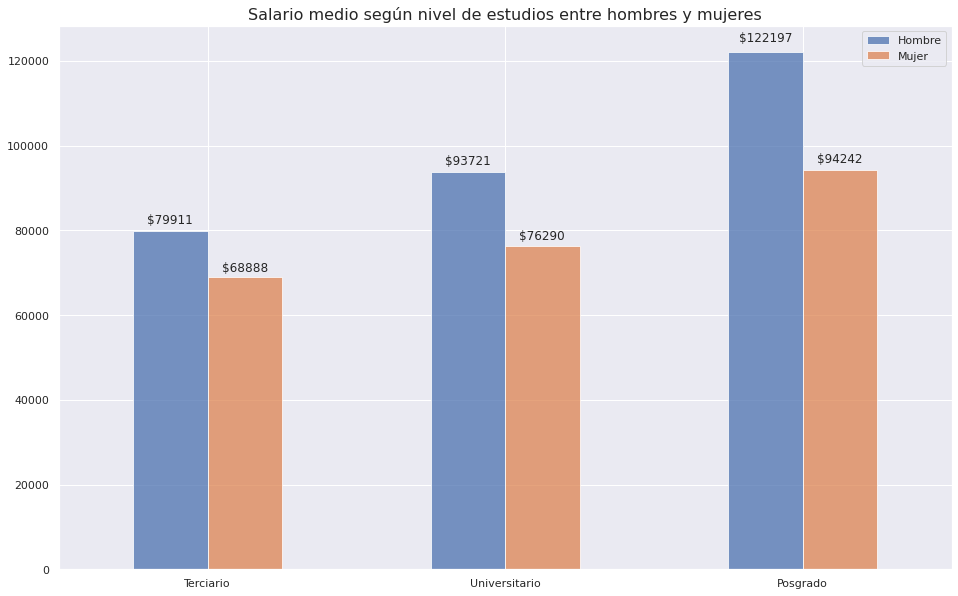

In [ ]:
ax = dframe.plot(kind='bar',alpha=0.75, rot=0, figsize=(16,10))
plt.title("Salario medio según nivel de estudios entre hombres y mujeres",fontsize= 16)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'${height}', (x + width/2, y + height*1.02), ha='center')